In [1]:
%cd ~ /projects/GraB-lib

%load_ext autoreload
%autoreload 1

/home/aris/projects/GraB-lib


In [2]:
from torch import nn

import os
import sys
from functools import partial, reduce
from pathlib import Path
from dataclasses import dataclass, field

import evaluate
import numpy as np
import pandas as pd
import wandb
from tqdm import tqdm
from absl import logging

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from transformers import (
    HfArgumentParser, TrainingArguments, set_seed
)

import torchopt
from torch.func import (
    grad, grad_and_value, vmap, functional_call
)

from grabngo import GraBSampler, BalanceType
from grabngo.utils import EventTimer, pretty_time

from experiments.cv.models import LeNet

In [3]:
device = "cuda"
batch_size = 16
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.49139968, 0.48215841, 0.44653091],
            std=[0.24703223, 0.24348513, 0.26158784],
        ),
    ]
)

# Loading the dataset and preprocessing
train_dataset = datasets.CIFAR10(
    root="data/external", train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root="data/external", train=False, download=True, transform=transform
)

in_dim, num_classes = 3, 10

loss_fn = nn.CrossEntropyLoss().to(device)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    # sampler=sampler,
    persistent_workers=False,
    num_workers=1,
    pin_memory=True,
)
train_eval_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    persistent_workers=False,
    num_workers=1,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    persistent_workers=False,
    num_workers=1,
    pin_memory=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
logging.set_verbosity(logging.INFO)

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [6]:
@torch.no_grad()
def unfold_model(model):
    return torch.cat([
        p.view(-1) for p in model.parameters()
    ])

In [7]:
checkpoint_path = Path(
    'checkpoints/cifar10/lenet/cifar10_lenet_rr_sgd_lr_0.01_wd_0.01_b_16_seed_42_epoch_100.pt')

trained_model = LeNet().cuda()
trained_model.load_state_dict(torch.load(checkpoint_path))

trained_weight = unfold_model(trained_model)

In [8]:
set_seed(42)

inited_model = LeNet().cuda()

inited_weight = unfold_model(inited_model)

In [9]:
diff = trained_weight - inited_weight

print(diff.abs().max())
print(diff.abs().min())
print(diff.abs().mean())
print(diff.abs().std())

print('-' * 20)

print(diff.max())
print(diff.min())
print(diff.mean())
print(diff.std())

tensor(0.7508, device='cuda:0')
tensor(7.7859e-07, device='cuda:0')
tensor(0.0361, device='cuda:0')
tensor(0.0323, device='cuda:0')
--------------------
tensor(0.5990, device='cuda:0')
tensor(-0.7508, device='cuda:0')
tensor(0.0004, device='cuda:0')
tensor(0.0484, device='cuda:0')


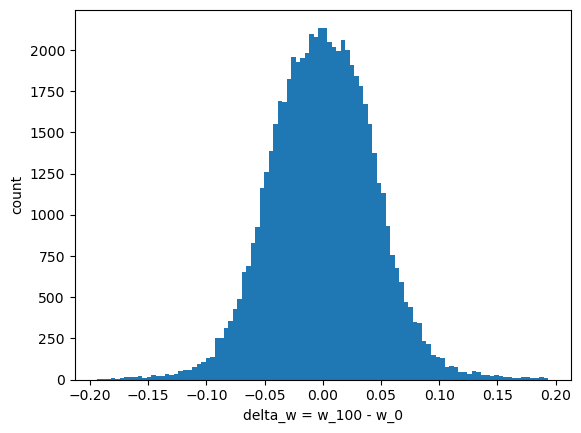

In [10]:
r = diff.std().item() * 4

plt.hist(diff.cpu().detach().numpy(), bins=100, range=(-r, r))
plt.xlabel('delta_w = w_100 - w_0')
plt.ylabel('count')
plt.show()

In [11]:
# https://stats.stackexchange.com/a/3444

import scipy.stats

print(scipy.stats.norm.ppf(0.125))
print(scipy.stats.norm.ppf(0.375))
print(scipy.stats.norm.ppf(0.625))
print(scipy.stats.norm.ppf(0.875))

quantiles = [0.125, 0.375, 0.625, 0.875]
quants = scipy.stats.norm.ppf(quantiles)

print(quants)



-1.1503493803760079
-0.31863936396437514
0.31863936396437514
1.1503493803760079
[-1.15034938 -0.31863936  0.31863936  1.15034938]


In [12]:
miu, sigma = diff.mean().item(), diff.std().item()

critics = sigma * quants + miu

critics

array([-0.05529658, -0.01501187,  0.01585536,  0.05614007])

In [82]:
# https://stackoverflow.com/a/2566508


def quantize(tensor, precision_bits=4):
    """replace the diff with certain specific values, and the number of unique
    values to choose from is 2^precision_bits
    """
    rep_nums = 2 ** precision_bits

    r_inv = 1 / rep_nums / 2
    # quants = torch.tensor(
    #     scipy.stats.norm.ppf(np.linspace(r_inv, 1, rep_nums) - r_inv / 2),
    #     device="cuda",
    # )

    quants = torch.tensor(
        scipy.stats.norm.ppf(np.linspace(r_inv, 1 - r_inv, rep_nums - 1)),
        device="cuda",
    )

    miu, std = tensor.mean(), tensor.std()
    # logging.info(f"miu: {miu}, std: {std}")
    critics = quants * std + miu
    # logging.info(f'critics: {critics}')
    idx = (tensor[:, None] - quants).abs().argmin(dim=1)
    # logging.info(idx)
    # print(pd.Series(idx.cpu().numpy()).describe())
    return critics[idx]


def compress(tensor, outlier_multiplier=2, add_noise=False, seed=42):
    quants = torch.tensor(
        # scipy.stats.norm.ppf([0.33, 0.5, 0.67]),
        scipy.stats.norm.ppf([0.5]),
        device="cuda",
    )

    miu, std = tensor.mean(), tensor.std()
    logging.info(f"miu: {miu}, std: {std}")
    # critics = quants * std + miu
    critics = quants * std
    idx = (tensor[:, None] - quants).abs().argmin(dim=1)
    result = critics[idx].float()

    outliers_mask = (tensor).abs() > outlier_multiplier * std

    sparsity = outliers_mask.sum() / len(tensor)

    logging.info(
        f"{outliers_mask.sum()} outliers, {sparsity * 100:.2f}%"
    )
    result[outliers_mask] = tensor[outliers_mask]

    if add_noise:
        rng = torch.Generator(device="cuda").manual_seed(seed)
        n = (~outliers_mask).sum()
        result[~outliers_mask] = torch.normal(
            mean=miu.repeat(n), std=std.repeat(n), generator=rng
        )
    # print(miu, std, result[~outliers_mask][:20])

    return result, sparsity


# quant_diff = quantize(diff, precision_bits=10)
quant_diff, _ = compress(
    diff,
    outlier_multiplier=.4,
    add_noise=False,
)

print(quant_diff.mean())
print(quant_diff.std())
print(quant_diff.max())
print(quant_diff.min())

import pandas as pd

print(pd.Series(quant_diff.cpu().numpy()).describe())
print(quant_diff[:20])

INFO:absl:miu: 0.00042174223926849663, std: 0.0484360009431839
INFO:absl:41514 outliers, 66.95%


tensor(0.0004, device='cuda:0')
tensor(0.0480, device='cuda:0')
tensor(0.5990, device='cuda:0')
tensor(-0.7508, device='cuda:0')
count    62006.000000
mean         0.000403
std          0.048015
min         -0.750775
25%         -0.029956
50%          0.000000
75%          0.029916
max          0.599020
dtype: float64
tensor([ 0.0000, -0.0368,  0.0595, -0.0715,  0.0929,  0.1213,  0.1869, -0.0469,
        -0.1581,  0.0854,  0.0405,  0.1664, -0.0221, -0.0980, -0.1377,  0.0867,
         0.0600,  0.0577,  0.0000, -0.1545], device='cuda:0')


In [45]:
@torch.no_grad()
def apply_diff(module, delta):
    idx = 0
    for p in module.parameters():
        d = p.numel()
        p += delta[idx:idx + d].reshape(p.shape)
        idx += d


set_seed(42)

inited_model = LeNet().cuda()

apply_diff(inited_model, quant_diff)

diff_model = inited_model

set_seed(42)

inited_model = LeNet().cuda()

assert not torch.allclose(next(inited_model.parameters()),
                          next(diff_model.parameters()))

In [46]:
@torch.no_grad()
def validate(
        test_loader,
        model,
        loss_fn,
        no_tqdm=False,
        device: torch.device = torch.device("cuda"),
):
    metric = evaluate.load('accuracy')
    running_loss = 0.0
    # look over the validation dataloader
    for _, (x, y) in tqdm(
            enumerate(test_loader), total=len(test_loader), leave=False, disable=no_tqdm
    ):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        loss = loss_fn(outputs, y)
        running_loss += loss.item()
        metric.add_batch(predictions=outputs.argmax(dim=-1), references=y)
    return running_loss / len(test_loader), metric.compute()


loss, acc = validate(
    test_loader=test_loader,
    model=trained_model,
    loss_fn=loss_fn,
)

print(f"loss: {loss} accuracy: {acc['accuracy']}")

loss: 1.0265841662168502 accuracy: 0.6512


In [47]:

loss, acc = validate(
    test_loader=test_loader,
    model=diff_model,
    loss_fn=loss_fn,
)

print(f"loss: {loss} accuracy: {acc['accuracy']}")

loss: 1.1016650958538055 accuracy: 0.6275


In [17]:

loss, acc = validate(
    test_loader=test_loader,
    model=LeNet().cuda(),
    loss_fn=loss_fn,
)

print(f"loss: {loss} accuracy: {acc['accuracy']}")

loss: 2.305190079498291 accuracy: 0.1004


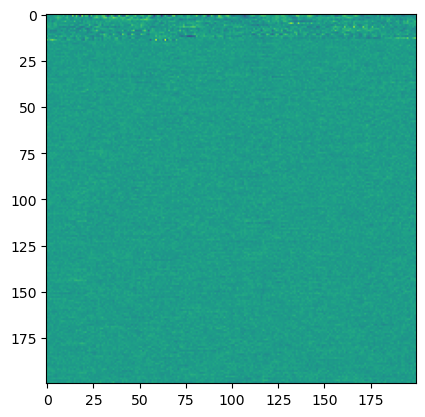

In [30]:
size = 200
plt.imshow(diff[:size ** 2].reshape(size, size).cpu().detach().numpy())

In [33]:
from torchinfo import summary

summary(trained_model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [10]                      --
├─Sequential: 1-1                        [1, 120, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 6, 28, 28]            456
│    └─ReLU: 2-2                         [1, 6, 28, 28]            --
│    └─MaxPool2d: 2-3                    [1, 6, 14, 14]            --
│    └─Conv2d: 2-4                       [1, 16, 10, 10]           2,416
│    └─ReLU: 2-5                         [1, 16, 10, 10]           --
│    └─MaxPool2d: 2-6                    [1, 16, 5, 5]             --
│    └─Conv2d: 2-7                       [1, 120, 1, 1]            48,120
│    └─ReLU: 2-8                         [1, 120, 1, 1]            --
├─Sequential: 1-2                        [10]                      --
│    └─Linear: 2-9                       [84]                      10,164
│    └─ReLU: 2-10                        [84]                      --
│  

In [57]:
multipliers = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 3]

losses, accs, sparsities = [], [], []
for m in multipliers:
    set_seed(42)
    model = LeNet().cuda()

    quant_diff, sparsity = compress(
        diff,
        outlier_multiplier=m,
        add_noise=False,
    )
    apply_diff(model, quant_diff)
    loss, acc = validate(test_loader, model, loss_fn)

    losses.append(loss)
    accs.append(acc)
    sparsities.append(sparsity)

INFO:absl:61476 outliers, 99.15%


INFO:absl:59344 outliers, 95.71%                  
INFO:absl:56633 outliers, 91.33%                  
INFO:absl:51597 outliers, 83.21%                  
INFO:absl:46530 outliers, 75.04%                  
INFO:absl:41514 outliers, 66.95%                  
INFO:absl:36594 outliers, 59.02%                  
INFO:absl:31806 outliers, 51.30%                  
INFO:absl:27449 outliers, 44.27%                  
INFO:absl:23217 outliers, 37.44%                  
INFO:absl:19384 outliers, 31.26%                  
INFO:absl:16109 outliers, 25.98%                  
INFO:absl:5841 outliers, 9.42%                    
INFO:absl:2131 outliers, 3.44%                    
INFO:absl:597 outliers, 0.96%                     


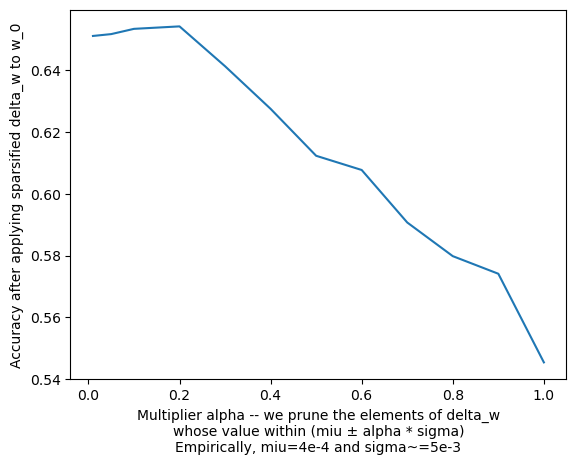

In [84]:
plt.plot(multipliers[:-3], [e['accuracy'] for e in accs][:-3])
plt.xlabel(
    'Multiplier alpha -- we prune the elements of delta_w\nwhose value within (miu ± alpha * sigma)\nEmpirically, miu=4e-4 and sigma~=5e-3')
plt.ylabel('Accuracy after applying sparsified delta_w to w_0')
plt.show()

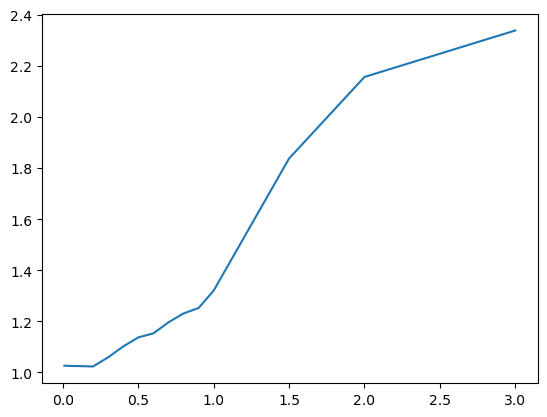

In [59]:
plt.plot(multipliers, losses)

In [66]:
densities = sparsities

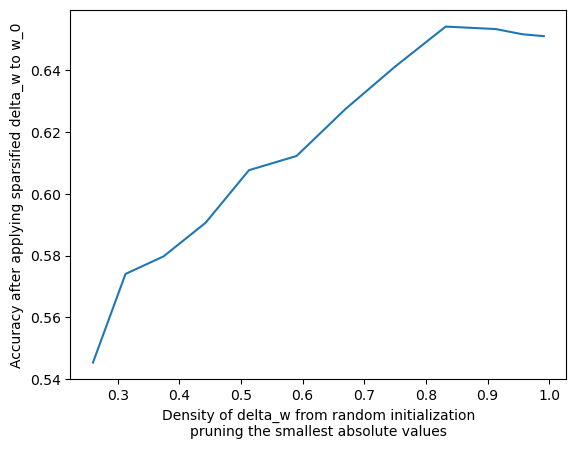

In [77]:
plt.plot([s.cpu() for s in densities][:-3], [e['accuracy'] for e in accs][:-3])
plt.xlabel(
    'Density of delta_w from random initialization\nafter pruning the smallest absolute values')
plt.ylabel('Accuracy after applying sparsified delta_w to w_0')
plt.show()

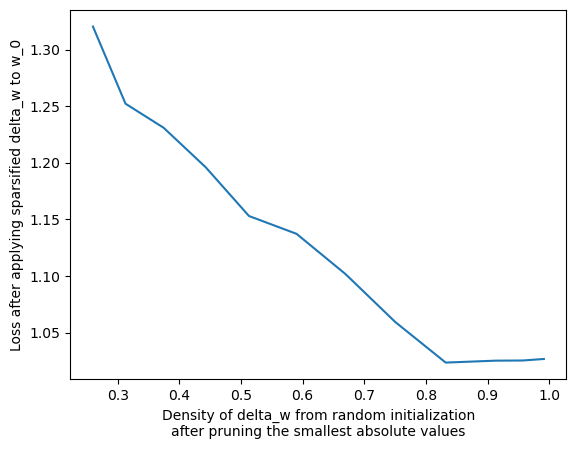

In [78]:
plt.plot([s.cpu() for s in densities][:-3], losses[:-3])
plt.xlabel(
    'Density of delta_w from random initialization\nafter pruning the smallest absolute values')
plt.ylabel('Loss after applying sparsified delta_w to w_0')
plt.show()